In [12]:
import numpy as np
import pandas as pd
import ruptures as rpt
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift

In [2]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [3]:
info_wo_tle_df = pd.read_csv('File/info_wo_tle_df.csv', index_col=0)
name = 'perigee'
df = info_wo_tle_df[['year', 'month', 'day', 'hour', name]]

In [4]:
df_1 = df.copy()
df_1.loc[:, 'datetime'] = pd.to_datetime(df_1[['year', 'month', 'day', 'hour']])
df_1.set_index('datetime', inplace=True)
df_1.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_1 = df_1.resample('h').mean()

In [5]:
if name == 'altitude' or 'velocity':
    df_2 = df_1.rolling(window=120).mean().dropna()
df_2 = df_1

In [6]:
window = 500
ol_idxs = []
for i in range(window, 5400 - window, 1):
    window_diff = df_2[i - window: i]
    z_norm = ((window_diff - window_diff.mean()) / window_diff.std())
    final_val = float(z_norm.values[-1])

    if np.abs(final_val) > 3:
        ol_idxs.append(i)

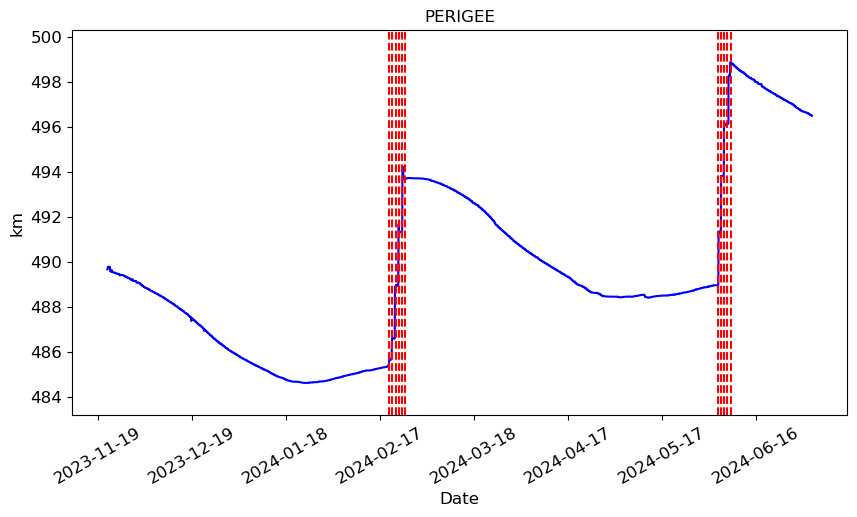

In [7]:
draw_graph(df_2, name.upper(), 'km',
           pd.DataFrame(df_2.iloc[ol_idxs].index.date).drop_duplicates().values.tolist(), "blue")

In [31]:
model = "l2"
algo = rpt.Binseg(model=model).fit(df_2.values)
result = algo.predict(pen=10000)

In [32]:
result=[p-1 for p in result]

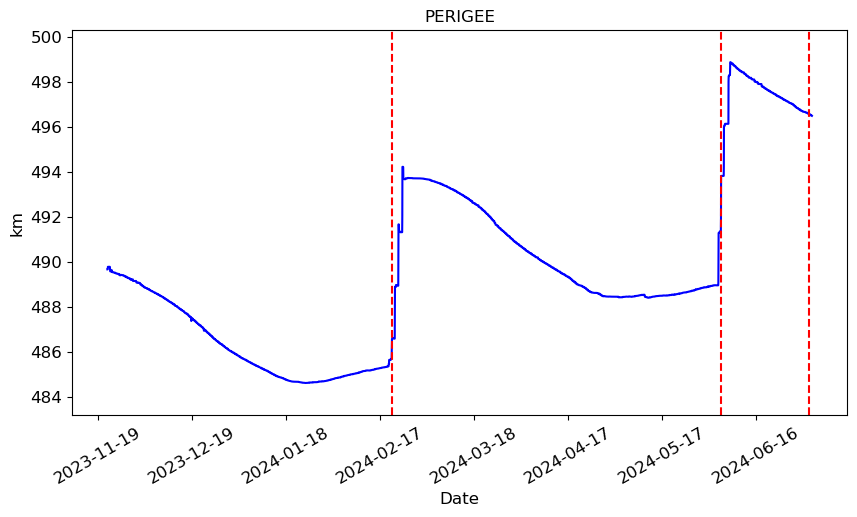

In [33]:
draw_graph(df_2, name.upper(), 'km',
           pd.DataFrame(df_2.iloc[result].index.date).drop_duplicates().values.tolist(), "blue")

In [74]:
class oneSidedCUSUM:
    def __init__(self, delta, h=None):
        self.delta = delta
        self.h = h
        self.G_list = None
        self.S_list = None
        self.G_min_idx = None
        self.cpd_idx = None
        
    def mean(self, x, k):
        if k == 0:
            return x[k]
        return np.mean(x[:k])
    
    def var(self, x, k):
        return np.var(x[:k])
    
    def get_s_unknown(self, x, k, mu1, delta, sigma):
        temp = (delta/sigma)*(x[k] - mu1 - 0.5*delta)
        return temp
    
    def find_change_point(self, signal):
        G_list = []
        S_list = []
        G = 0
        S = 0
        delta = self.delta
        for k in range(len(signal)):
            if k == 0: ## 초기값
                sigma = 1
                mu1 = 0
            else: ## 평균과 분산 추정
                mu1 = self.mean(signal, k+1)
                sigma = self.var(signal, k+1)
            s = self.get_s_unknown(signal, k, mu1, delta, sigma) ## 개별 로그 우도비
            G = np.max([G+float(s), 0]) ## 일반화 우도비
            S = S + s ## 개별 로그 우도비 누적합
            G_list.append(G)
            S_list.append(S)
            
        self.G_list = G_list
        self.S_list = S_list
        if self.h is not None:
            ## 일반화 우도비가 h를 넘어가는 인덱스
            self.G_min_idx = np.min(np.where(np.array(G_list) > self.h)[0])
            target_S_list = S_list[:self.G_min_idx] ## 인덱스 범위 제한
            self.cpd_idx = target_S_list.index(min(target_S_list)) ## 개별 로그 우도비 누적합이 최소가 되는 인덱스
        return self

In [54]:
class twoSidedCUSUM:
    def __init__(self, delta, h=None):
        self.delta = delta
        self.h = h
        self.G_increase_list = None
        self.S_increase_list = None
        self.G_decrease_list = None
        self.S_decrease_list = None
        self.G_increase_min_idx = None
        self.increase_cpd_idx = None
        self.G_decrease_min_idx = None
        self.decrease_cpd_idx = None

    def mean(self, x, k):
        if k == 0:
            return x[k]
        return np.mean(x[:k])

    def var(self, x, k):
        return np.var(x[:k])

    def get_s_unknown(self, x, k, mu1, sigma, sign):
        delta = abs(self.delta)
        if sign == 1:
            temp = (delta / sigma) * (x[k] - mu1 - 0.5 * delta)
        else:
            temp = -(delta / sigma) * (x[k] - mu1 + 0.5 * delta)
        return temp

    def find_change_point(self, signal):
        G_increase_list = []
        S_increase_list = []
        G_decrease_list = []
        S_decrease_list = []

        G_i = 0
        S_i = 0
        G_d = 0
        S_d = 0

        for k in range(len(signal)):
            if k == 0:
                sigma = 1
                mu1 = 0
            else:
                mu1 = self.mean(signal, k + 1)
                sigma = self.var(signal, k + 1)
            s_i = self.get_s_unknown(signal, k, mu1, sigma, 1)
            s_d = self.get_s_unknown(signal, k, mu1, sigma, -1)
            G_i = np.max([G_i + float(s_i), 0])
            G_d = np.max([G_d + float(s_d), 0])
            S_i += s_i
            S_d += s_d
            G_increase_list.append(G_i)
            S_increase_list.append(S_i)
            G_decrease_list.append(G_d)
            S_decrease_list.append(S_d)

        self.G_increase_list = G_increase_list
        self.S_increase_list = S_increase_list
        self.G_decrease_list = G_decrease_list
        self.S_decrease_list = S_decrease_list

        # if self.h is not None:
        #     self.G_increase_min_idx = np.min(np.where(np.array(G_increase_list) > self.h)[0])
        #     target_S_increase_list = S_increase_list[:self.G_increase_min_idx]
        #     self.increase_cpd_idx = target_S_increase_list.index(min(target_S_increase_list))
        # 
        #     self.G_decrease_min_idx = np.min(np.where(np.array(G_decrease_list) > self.h)[0])
        #     target_S_decrease_list = S_decrease_list[:self.G_decrease_min_idx]
        #     self.decrease_cpd_idx = target_S_decrease_list.index(min(target_S_decrease_list))
        return self